In [1]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error


import yaml 
import time

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
len_string = '35-100bp'
samples_yaml = '../../CRPC/TFBS_'+len_string+'_nucleosome_profiling/config/samples.GC.yaml'
single_fragment_length_dir ='../../Griffin_single_fragment_length/CRPC_deep/CRPC_'+len_string+'_single_fragment_length_np/results/'
multi_fragment_length_dir ='../../CRPC/TFBS_'+len_string+'_nucleosome_profiling/results/'
tfx_path = '../../metadata/CRPC/deepWGS_tumor_fraction.txt'

out_dir = 'files'

In [3]:
with open(samples_yaml, 'r') as f:
    samples = yaml.safe_load(f)
    
samples = list(samples['samples'].keys())


In [4]:
#import data
single_fragment_data = pd.DataFrame()
multi_fragment_data = pd.DataFrame()

for sample in samples:
    file1 = single_fragment_length_dir+sample+'/'+sample+'.GC_corrected.coverage.tsv'
    data1 = pd.read_csv(file1, sep='\t')
    single_fragment_data = single_fragment_data.append(data1)
    
    file2 = multi_fragment_length_dir+sample+'/'+sample+'.GC_corrected.coverage.tsv'
    data2 = pd.read_csv(file2, sep='\t')
    multi_fragment_data = multi_fragment_data.append(data2)

#merge with tumor fraction
tfx_data = pd.read_csv(tfx_path, sep='\t').rename(columns = {'ID':'sample'})
single_fragment_data = single_fragment_data.merge(tfx_data, on = 'sample')

multi_fragment_data = multi_fragment_data.merge(tfx_data, on = 'sample')

In [5]:
data = {'single_fragment_length':single_fragment_data,
        'multi_fragment_length':multi_fragment_data}

In [6]:
sites = multi_fragment_data['site_name'].unique()
len(sites)

377

In [7]:
stat_results = {}
analysis_types = data.keys()

for i,item in enumerate(analysis_types): 
    stat_results[item] = pd.DataFrame()

for k,site_name in enumerate(sites):
    if k%50==0:
        print(k,site_name)
    for i,item in enumerate(analysis_types): 
            current_data = data[item].copy()
            current_data = current_data[current_data['site_name']==site_name]
            current_outputs = {'site_name':site_name}
            for feature in ['mean_coverage','central_coverage','amplitude']:
                #pearson r plus regression line
                lin_reg_slope, lin_reg_intercept, pearson_r, pearson_pval, lin_reg_std_err = linregress(current_data['tumor_fraction'],current_data[feature])
                fit_line = lin_reg_slope*current_data['tumor_fraction']+lin_reg_intercept

                RMSE = np.sqrt(mean_squared_error(current_data[feature],fit_line))
                current_outputs['pearson_r_'+feature] = pearson_r
                current_outputs['pearson_pval_'+feature] = pearson_pval
                current_outputs['lin_reg_slope_'+feature] = lin_reg_slope
                current_outputs['lin_reg_intercept_'+feature] = lin_reg_intercept
                #current_outputs['lin_reg_r2_'+feature] = r2
                current_outputs['lin_reg_RMSE_'+feature] = RMSE
            stat_results[item] = stat_results[item].append(current_outputs, ignore_index=True)


0 AHR.hg38.10000
50 ELK4.hg38.10000
100 HIF3A.hg38.10000
150 MEF2A.hg38.10000
200 OTX2.hg38.10000
250 SMAD5.hg38.10000
300 TLX1.hg38.10000
350 ZNF316.hg38.10000


In [8]:
#export for supplemental table
keep_cols = ['site_name', 
             'pearson_r_central_coverage','pearson_pval_central_coverage', 'lin_reg_RMSE_central_coverage',
             'pearson_r_mean_coverage', 'pearson_pval_mean_coverage','lin_reg_RMSE_mean_coverage',
             'pearson_r_amplitude', 'pearson_pval_amplitude','lin_reg_RMSE_amplitude']

for i,item in enumerate(analysis_types): 
    stat_results[item][keep_cols].to_csv(out_dir+'/'+item+'_'+len_string+'.tsv', sep='\t', index=False)


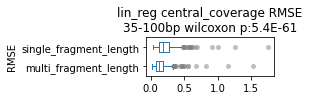

medians:
single_fragment_length    0.180
multi_fragment_length     0.131
dtype: float64
number improved:
360
0.95




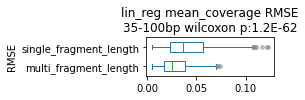

medians:
single_fragment_length    0.036
multi_fragment_length     0.026
dtype: float64
number improved:
366
0.97




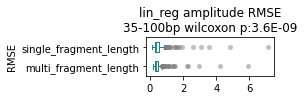

medians:
single_fragment_length    0.391
multi_fragment_length     0.362
dtype: float64
number improved:
226
0.6




In [9]:
#make boxplots


for feature in ['central_coverage','mean_coverage','amplitude']:
    boxplot_data = pd.DataFrame(index = sites)
    for i,item in enumerate(['multi_fragment_length','single_fragment_length']): 
            current_data = stat_results[item][['lin_reg_RMSE_'+feature,'site_name']].set_index('site_name').copy()
            boxplot_data[item] = current_data

    fig,ax = plt.subplots(1, figsize=(4,1.5))


    boxplot_data.plot.box(ax = ax, vert = False, widths = .5, flierprops = {'marker':'.','markersize':10,'alpha':.5,'markerfacecolor':'grey','markeredgecolor':'none'})
    stat,wilcoxon_pval = wilcoxon(boxplot_data['single_fragment_length'],boxplot_data['multi_fragment_length'])
    
    ax.set_title('lin_reg '+feature+' RMSE\n'+len_string+' wilcoxon p:'+'{:.1E}'.format(wilcoxon_pval))
    ax.set_ylabel('RMSE')    
    #ax.tick_params(axis = 'x', rotation=90)
    fig.tight_layout()
    fig.savefig('plots/'+feature+'_'+len_string+'_RMSE_plot.pdf')

    plt.show()
    print('medians:')
    print(np.round(boxplot_data[['single_fragment_length','multi_fragment_length']].median(),3))
    print('number improved:')
    print(sum(boxplot_data['single_fragment_length']>boxplot_data['multi_fragment_length']))
    print(np.round(sum(boxplot_data['single_fragment_length']>boxplot_data['multi_fragment_length'])/len(boxplot_data),2))

    print('\n')

In [10]:
boxplot_data

,multi_fragment_length,single_fragment_length
AHR.hg38.10000,0.213878,0.355494
AR.hg38.10000,0.433186,0.432433
ARID3A.hg38.10000,0.339314,0.355649
ARNT.hg38.10000,0.324176,0.287341
ARNTL.hg38.10000,0.435124,0.362014
...,...,...
ZNF792.hg38.10000,0.846010,0.947039
ZSCAN16.hg38.10000,0.733138,0.529491
ZSCAN22.hg38.10000,0.511772,0.583547
ZSCAN4.hg38.10000,0.803887,0.686841


In [11]:
# wilcoxon(np.append(np.arange(-226,0),np.arange(1,152)))